# Prueba comparador de estrategias

In [1]:
import datetime
import pandas as pd
import sys

sys.path.append(r'../2_avisos_cambio_fondos')
sys.path.append(r'../3_simulador')

from estrategias import Estrategia
from valores_cuota import df_valores_cuota

from comparador import agrega_estrategias

# PARAMETROS PARA DEFINIR LA ESTRATEGIA
fecha_ini = datetime.datetime.strptime('2012-01-01', '%Y-%m-%d').date()
fecha_end = datetime.datetime.strptime('2015-01-01', '%Y-%m-%d').date()


estrategia_ff = Estrategia(fecha_ini, fecha_end, 'FF', 'anuncios_ff.xlsx')
estrategia_a = Estrategia(fecha_ini, fecha_end, 'A')

lista_estrategias = [estrategia_ff, estrategia_a]

afp = 'HABITAT'
monto_inicial = 100
lag_solicitud = 0

df = agrega_estrategias(lista_estrategias, afp, monto_inicial, lag_solicitud)
df

,Fecha,Val_FF_lag_0,Val_A_lag_0
0,2012-01-01,100.000000,100.000000
1,2012-01-02,100.056200,99.928964
2,2012-01-03,100.101829,99.929761
3,2012-01-04,100.105917,100.813092
4,2012-01-05,100.216996,100.834698
...,...,...,...
1038,2014-12-28,130.761859,136.444175
1039,2014-12-29,130.797511,136.529363
1040,2014-12-30,130.805634,136.827182
1041,2014-12-31,130.946979,136.558583


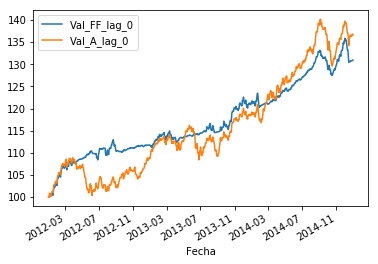

In [3]:
df.set_index('Fecha').plot()